In [ ]:
# Librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
# Adding scipy.stats for pearsonr
from scipy.stats import pearsonr

In [ ]:
# Archivos y nombres de las ciudades
archivos = {
    "Pasto": "/content/DPA.csv",
    "Pereira": "/content/DPE.csv",
    "Valledupar": "/content/DVA.csv"
}

# Umbrales
umbral_radiacion = 100  # Umbral para considerar una hora como "solar"
umbral_viabilidad = 400  # Umbral para días viables
resultados = {}

In [ ]:
def cargar_datos(nombre_ciudad, archivo):
    # Cargar los datos
    df = pd.read_csv(archivo)
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df['Dia'] = df['Fecha'].dt.date
    df['Hora'] = df['Fecha'].dt.hour

    # Transformar datos
    df_transformed = df.pivot_table(
        index="Fecha",
        columns="Variable",
        values="Valor"
    ).reset_index()

    df_transformed.rename(columns={
        "RAD SOLAR": "Radiación Solar (Wh/m^2)",
        "VEL VIENTO": "Velocidad Viento (m/s)"
    }, inplace=True)

    df_transformed = df_transformed.dropna()
    df_transformed['Dia'] = df_transformed['Fecha'].dt.date
    df_transformed['Hora'] = df_transformed['Fecha'].dt.hour

    print(f"Datos cargados y transformados para {nombre_ciudad}")
    return df_transformed

In [ ]:
def calcular_promedio_diario(df):
    promedio_diario = df.groupby('Dia')['Radiación Solar (Wh/m^2)'].mean()
    print("Promedio diario calculado.")
    return promedio_diario

In [ ]:
def calcular_horas_solares(df, umbral):
    df['HoraSolar'] = (df['Radiación Solar (Wh/m^2)'] > umbral).astype(int)
    horas_solares = df.groupby('Dia')['HoraSolar'].sum()
    print("Horas solares calculadas.")
    return horas_solares

In [ ]:
def calcular_fluctuacion_diaria(df):
    fluctuacion_diaria = df.groupby('Dia')['Radiación Solar (Wh/m^2)'].std()
    print("Fluctuación diaria calculada.")
    return fluctuacion_diaria

In [ ]:
def calcular_dias_viables(df, umbral):
    radiacion_maxima = df.groupby('Dia')['Radiación Solar (Wh/m^2)'].max()
    dias_viables = radiacion_maxima[radiacion_maxima > umbral]
    print("Días viables calculados.")
    return dias_viables

In [ ]:
def calcular_correlacion(df):
    correlacion = df['Radiación Solar (Wh/m^2)'].corr(df['Velocidad Viento (m/s)'])
    print(f"Correlación calculada: {correlacion}")
    return correlacion

In [ ]:
def graficar_promedio_diario(promedio_diario, nombre_ciudad, umbral):
    plt.figure(figsize=(12, 6))
    plt.plot(promedio_diario, marker='o', label='Promedio Diario')
    plt.axhline(y=umbral, color='r', linestyle='--', label=f"Límite de Viabilidad ({umbral} Wh/m²)")
    plt.title(f"Comportamiento Diario de Radiación Solar - {nombre_ciudad}")
    plt.xlabel("Días")
    plt.ylabel("Radiación Solar (Wh/m²)")
    plt.grid()
    plt.legend()
    plt.show()
    print(f"Gráfico de promedio diario para {nombre_ciudad} mostrado.")

In [ ]:
def graficar_correlacion(df, nombre_ciudad):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        df['Radiación Solar (Wh/m^2)'],
        df['Velocidad Viento (m/s)'],
        alpha=0.5
    )
    plt.title(f"Correlación Radiación Solar vs Velocidad del Viento - {nombre_ciudad}")
    plt.xlabel("Radiación Solar (Wh/m²)")
    plt.ylabel("Velocidad del Viento (m/s)")
    plt.grid()
    plt.show()
    print(f"Gráfico de correlación para {nombre_ciudad} mostrado.")

In [ ]:
def analizar_ciudad(nombre_ciudad, archivo):
    df = cargar_datos(nombre_ciudad, archivo)
    promedio_diario = calcular_promedio_diario(df)
    horas_solares = calcular_horas_solares(df, umbral_radiacion)
    fluctuacion_diaria = calcular_fluctuacion_diaria(df)
    dias_viables = calcular_dias_viables(df, umbral_viabilidad)
    correlacion = calcular_correlacion(df)
    radiacion_maxim = radiacion_maxima = df.groupby('Dia')['Radiación Solar (Wh/m^2)'].max()
    # Graficar resultados
    graficar_promedio_diario(promedio_diario, nombre_ciudad, umbral_viabilidad)
    graficar_correlacion(df, nombre_ciudad)
    graficar_comportamiento(df, dias_viables)
    graficar_comportamiento_por_hora(df)
    # Guardar resultados en un diccionario
    resultados[nombre_ciudad] = {
        "Promedio Diario": promedio_diario,
        "Horas Solares": horas_solares,
        "Fluctuación Diaria": fluctuacion_diaria,
        "Días Viables": dias_viables.index.tolist(),
        "Correlación": correlacion
    }
        # 5. Crear la tabla final con los resultados
    df_resultado = pd.DataFrame({
        'Radiación Promedio Diaria': promedio_diario,
        'Horas Solares': horas_solares,
        'Fluctuación Radiación': fluctuacion_diaria,
        'Radiación Máxima': radiacion_maxima
    })
    # Guardar los resultados en un archivo CSV
    output_file = f"{nombre_ciudad.lower()}_analisis.csv"
    df_resultado.to_csv(output_file, index=True)

    # Mostrar la tabla en la consola
    print(f"Análisis completado para {nombre_ciudad}. Archivo generado: {output_file}")
    print(df_resultado)  # Esto imprimirá la tabla completa
    print(f"Análisis completo para {nombre_ciudad}.\n")

In [ ]:
def determinar_ciudades_viables(resultados):
    ciudades_viables = {
        ciudad: res for ciudad, res in resultados.items()
        if len(res["Días Viables"]) > 5 and res["Correlación"] > 0.5
    }
    print("Ciudades aptas para implementar paneles solares:", list(ciudades_viables.keys()))
    return ciudades_viables

In [ ]:
def calcular_metricas(df):
    df['Dia'] = df['Fecha'].dt.date
    radiacion_diaria = df.groupby('Dia')['Radiación Solar (Wh/m^2)'].mean()
    df['HoraSolar'] = np.where(df['Radiación Solar (Wh/m^2)'] > umbral_radiacion, 1, 0)
    horas_solares = df.groupby('Dia')['HoraSolar'].sum()
    fluctuacion_diaria = df.groupby('Dia')['Radiación Solar (Wh/m^2)'].std()
    radiacion_maxima = df.groupby('Dia')['Radiación Solar (Wh/m^2)'].max()

    # Filtrar días con radiación máxima superior a 400
    dias_viables = radiacion_maxima[radiacion_maxima > 400].index.tolist()

    return radiacion_diaria, horas_solares, fluctuacion_diaria, radiacion_maxima, dias_viables

In [ ]:
def graficar_comportamiento(df, dias_viables):
    """Graficar el comportamiento por hora y resaltar los días viables"""
    plt.figure(figsize=(14, 8))

    # Graficar para cada día
    for dia in df['Dia'].unique():
        datos_dia = df[df['Dia'] == dia]
        # Use the updated column name 'Radiación Solar (Wh/m^2)'
        plt.plot(datos_dia['Hora'], datos_dia['Radiación Solar (Wh/m^2)'], marker='o', label=f'Radiación Solar - {dia}')
        #plt.plot(datos_dia['Hora'], datos_dia['Velocidad Viento (m/s)'], marker='s', linestyle='--', label=f'Velocidad Viento - {dia}')

    # Línea de viabilidad de 400 Wh/m²
    plt.axhline(y=400, color='r', linestyle='-', linewidth=1.5, label='Límite de viabilidad (400 Wh/m²)')

    # Resaltar los días viables
    for dia in dias_viables.index:
        datos_dia = df[df['Dia'] == dia]
        plt.fill_between(
            datos_dia['Hora'],
            # Use the updated column name 'Radiación Solar (Wh/m^2)'
            datos_dia['Radiación Solar (Wh/m^2)'],
            400,
            where=(datos_dia['Radiación Solar (Wh/m^2)'] > 400),
            color='green',
            alpha=0.3,
            label=f'Día viable ({dia})' if f'Día viable ({dia})' not in plt.gca().get_legend_handles_labels()[1] else None
        )

    # Personalización del gráfico
    plt.title("Comportamiento por Hora y Días Viables", fontsize=14)
    plt.xlabel("Hora del Día", fontsize=12)
    plt.ylabel("Valor (Wh/m² y m/s)", fontsize=12)
    plt.xticks(range(0, 24))  # Mostrar las 24 horas
    plt.grid()
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Leyenda fuera del gráfico
    plt.tight_layout()

    # Mostrar la gráfica
    plt.show()

In [ ]:
def graficar_comportamiento_por_hora(df):
    """Graficar el comportamiento de la Radiación Solar y la Velocidad del Viento por hora para cada día, con doble eje."""

    sns.set(style="whitegrid")
    sns.jointplot(
        data=df,
        x="Radiación Solar (Wh/m^2)",
        y="Velocidad Viento (m/s)",
        kind="scatter"
    ).plot_joint(sns.regplot, scatter=False, color="red").plot_marginals(sns.histplot, kde=True, color="b")
    plt.suptitle(f"Correlación entre Rad. Solar y Vel. Viento - {archivos}", y=1.02, fontsize=16)
    plt.show()

Datos cargados y transformados para Pasto
Promedio diario calculado.
Horas solares calculadas.
Fluctuación diaria calculada.
Días viables calculados.
Correlación calculada: 0.20612841304482654


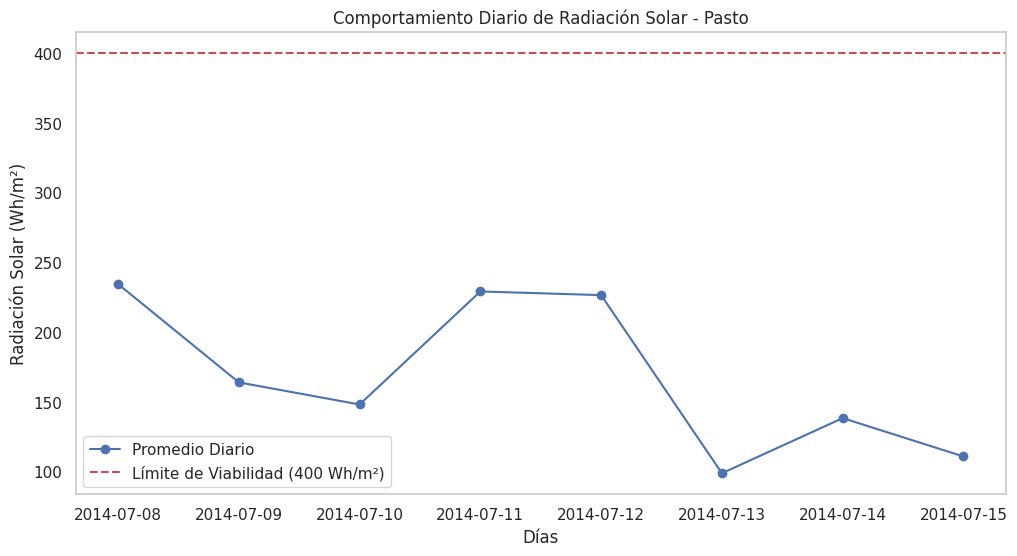

Gráfico de promedio diario para Pasto mostrado.


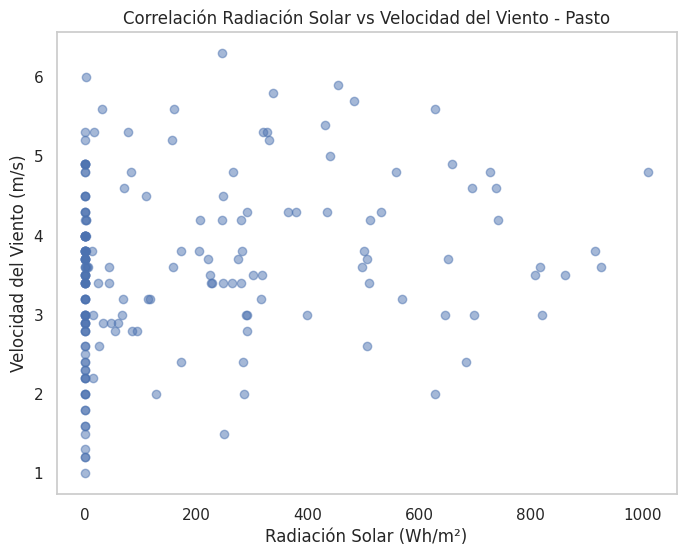

Gráfico de correlación para Pasto mostrado.


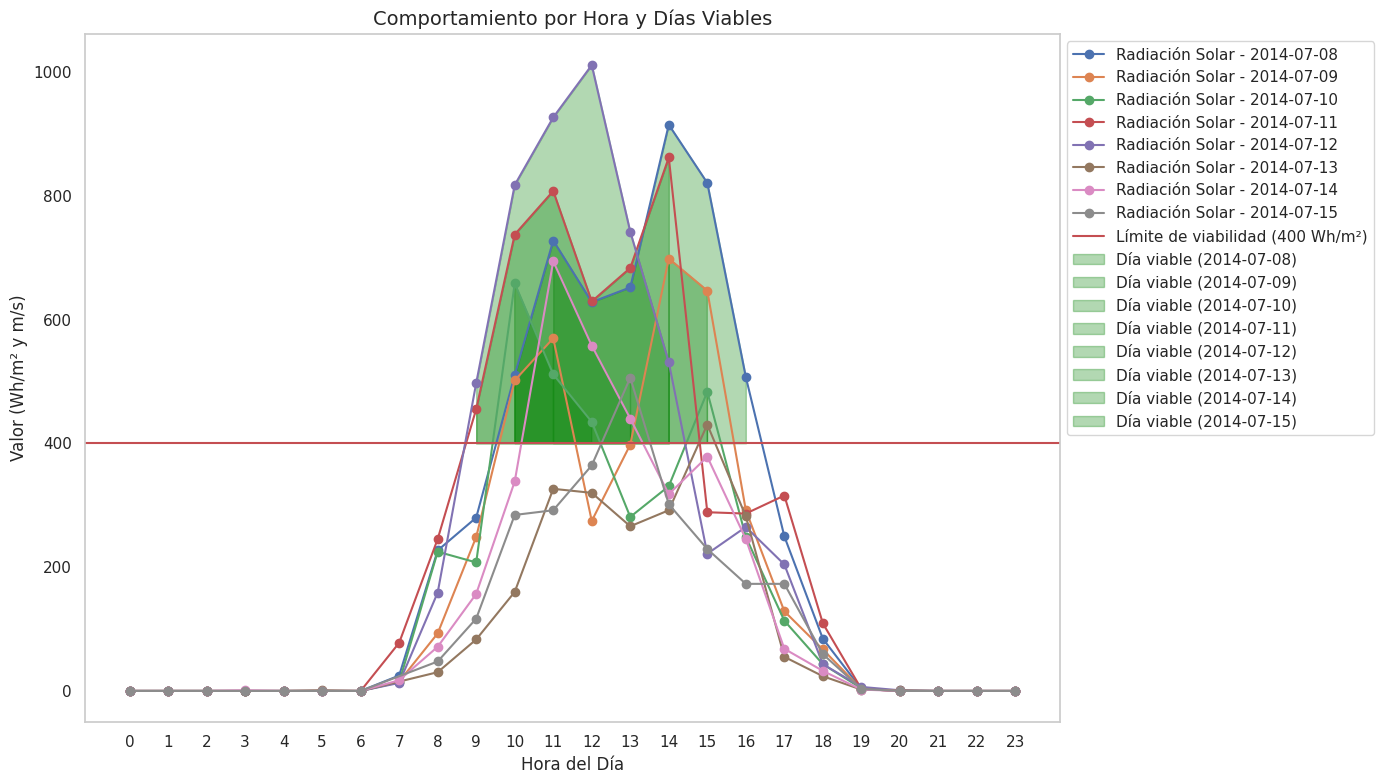

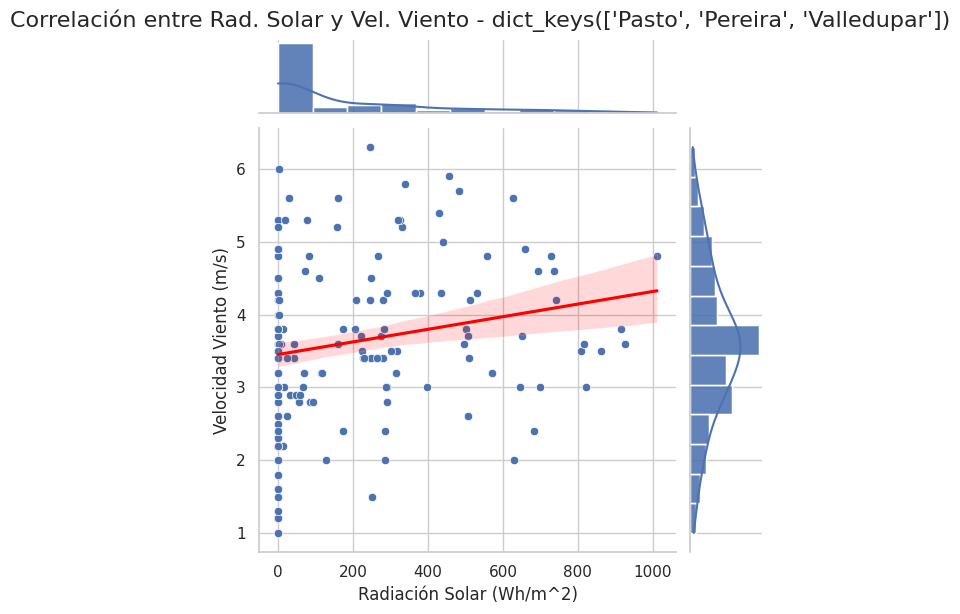

Análisis completado para Pasto. Archivo generado: pasto_analisis.csv
            Radiación Promedio Diaria  Horas Solares  Fluctuación Radiación  \
Dia                                                                           
2014-07-08                 234.554167             10             313.185530   
2014-07-09                 164.016667              9             232.854780   
2014-07-10                 148.162500             10             203.188351   
2014-07-11                 229.200000             11             301.508992   
2014-07-12                 226.583333             10             335.161218   
2014-07-13                  98.856522              7             141.748618   
2014-07-14                 138.391667              8             206.590620   
2014-07-15                 110.886957              9             149.967904   

            Radiación Máxima  
Dia                           
2014-07-08             914.6  
2014-07-09             698.4  
2014-07-10      

In [ ]:
analizar_ciudad("Pasto", archivos["Pasto"])  # Llena resultados["Pasto"]

Datos cargados y transformados para Pereira
Promedio diario calculado.
Horas solares calculadas.
Fluctuación diaria calculada.
Días viables calculados.
Correlación calculada: -0.036561462147463614


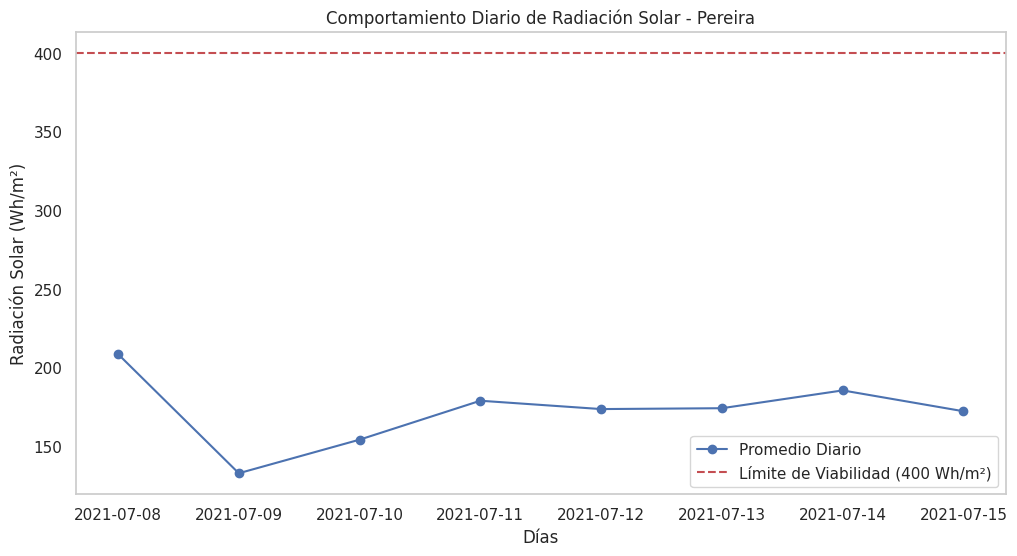

Gráfico de promedio diario para Pereira mostrado.


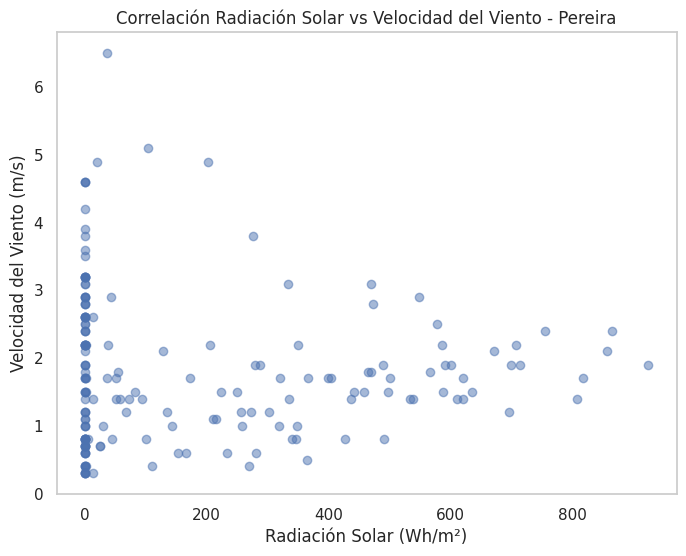

Gráfico de correlación para Pereira mostrado.


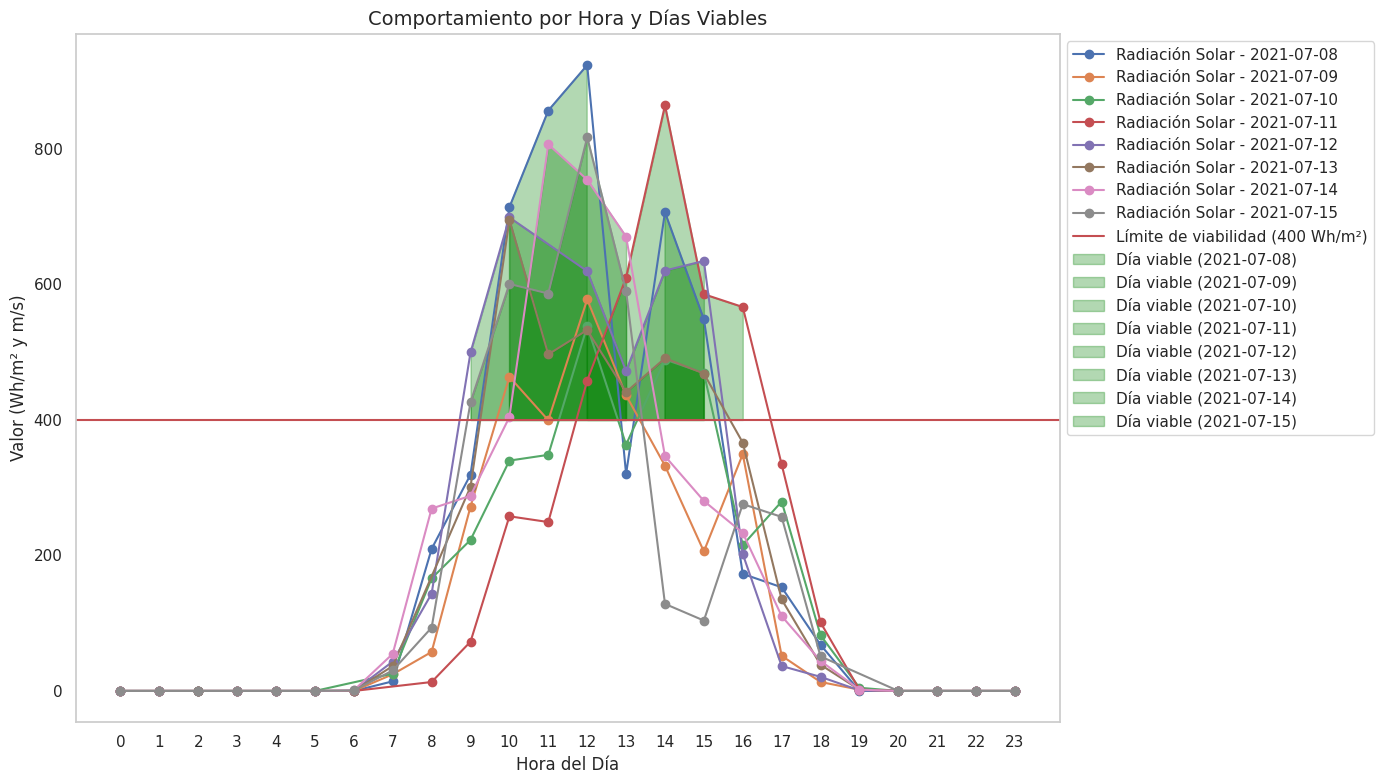

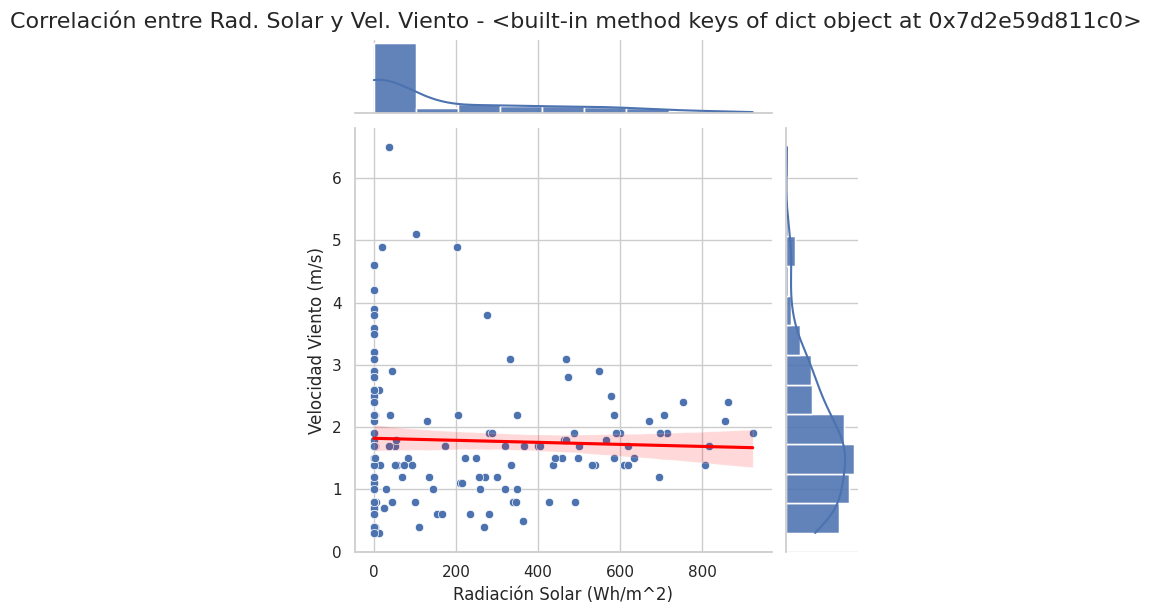

Análisis completado para Pereira. Archivo generado: pereira_analisis.csv
            Radiación Promedio Diaria  Horas Solares  Fluctuación Radiación  \
Dia                                                                           
2021-07-08                 208.612500             10             306.394997   
2021-07-09                 132.779167              8             190.182889   
2021-07-10                 154.152174             10             188.475284   
2021-07-11                 178.917391              9             262.232686   
2021-07-12                 173.613043              8             261.523950   
2021-07-13                 174.156522              9             235.255600   
2021-07-14                 185.486957             10             258.288271   
2021-07-15                 172.226087              9             252.410800   

            Radiación Máxima  
Dia                           
2021-07-08             923.7  
2021-07-09             578.0  
2021-07-10  

In [ ]:
analizar_ciudad("Pereira", archivos["Pereira"])  # Llena resultados["Pereira"]

Datos cargados y transformados para Valledupar
Promedio diario calculado.
Horas solares calculadas.
Fluctuación diaria calculada.
Días viables calculados.
Correlación calculada: 0.08854701665508477


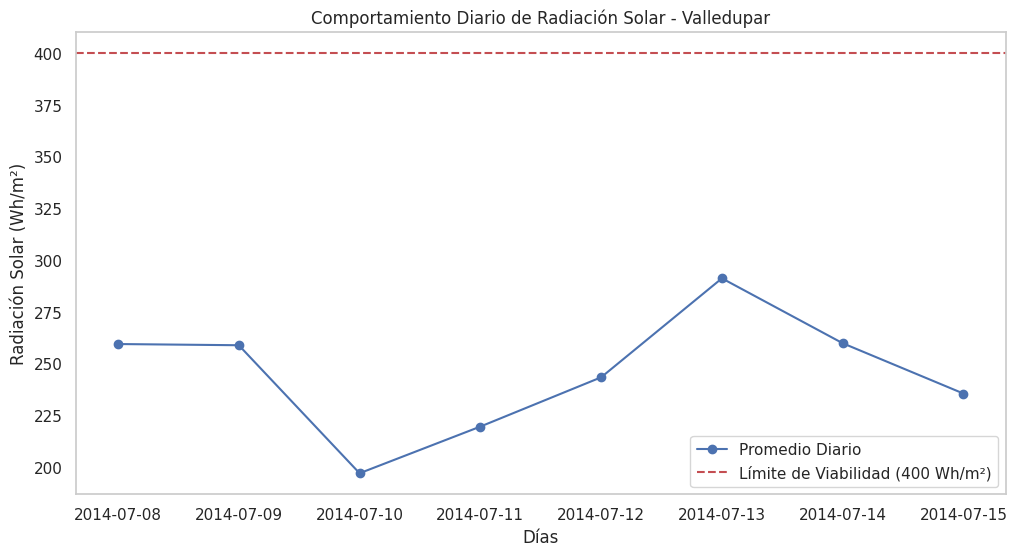

Gráfico de promedio diario para Valledupar mostrado.


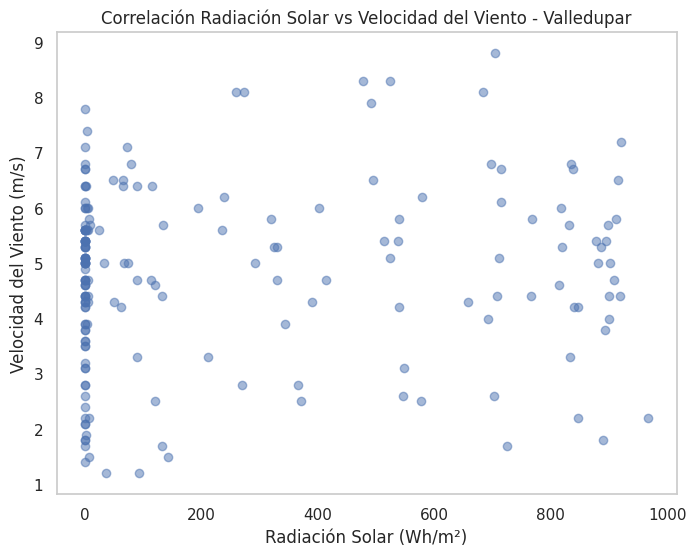

Gráfico de correlación para Valledupar mostrado.


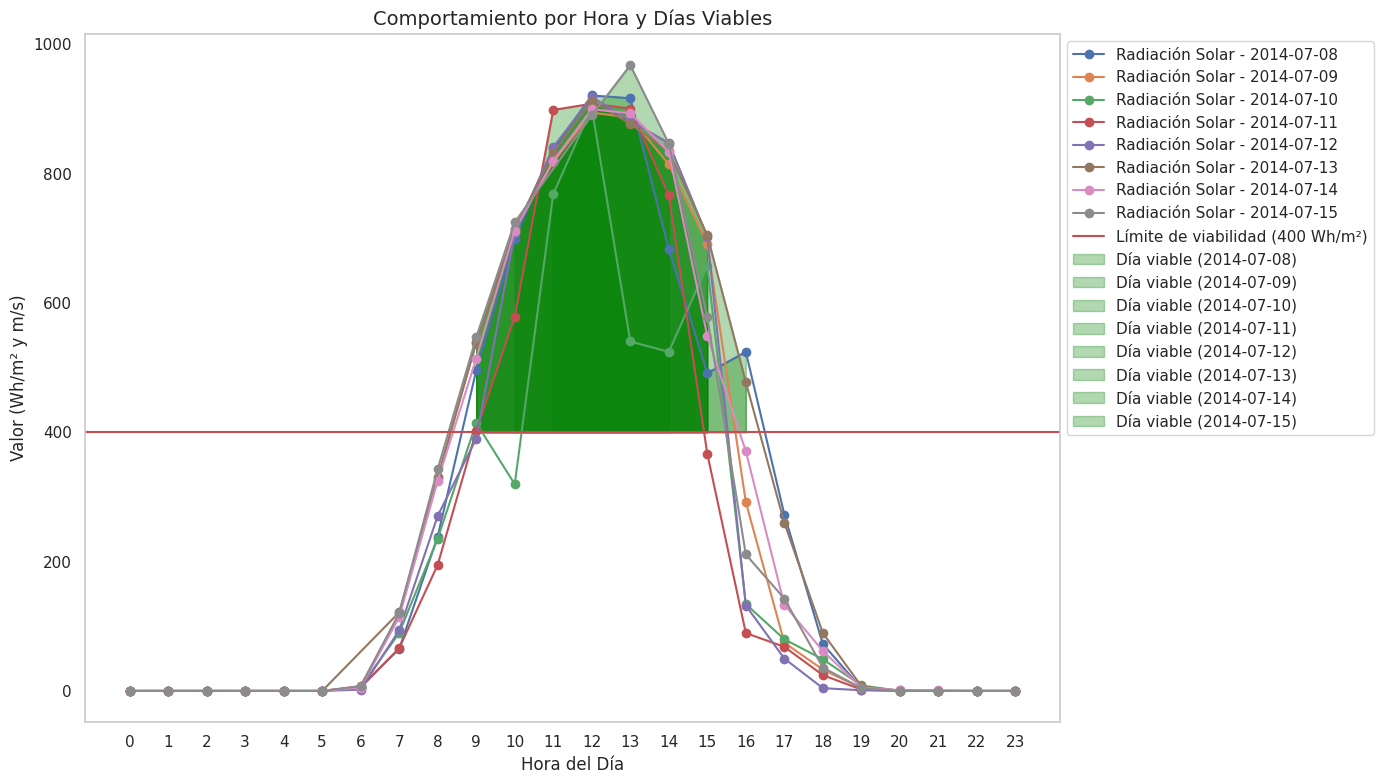

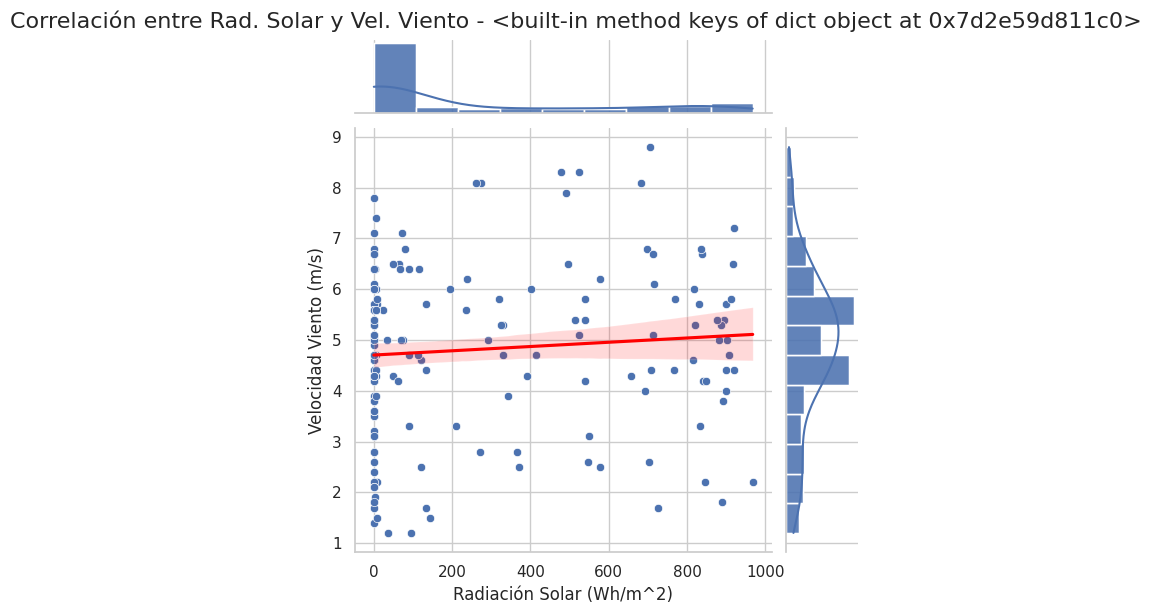

Análisis completado para Valledupar. Archivo generado: valledupar_analisis.csv
            Radiación Promedio Diaria  Horas Solares  Fluctuación Radiación  \
Dia                                                                           
2014-07-08                 259.487500             10             338.127606   
2014-07-09                 258.908333             10             348.922870   
2014-07-10                 197.050000              9             282.430650   
2014-07-11                 219.604167              8             333.492004   
2014-07-12                 243.412500              9             353.317243   
2014-07-13                 291.239130             11             354.316429   
2014-07-14                 259.875000             11             342.678547   
2014-07-15                 235.552174             10             338.699894   

            Radiación Máxima  
Dia                           
2014-07-08             920.7  
2014-07-09             894.1  
2014-0

In [ ]:
analizar_ciudad("Valledupar", archivos["Valledupar"])  # Llena resultados["Valledupar"]

In [ ]:
ciudades_viables = determinar_ciudades_viables(resultados)
print(ciudades_viables)

Ciudades aptas para implementar paneles solares: []
{}
